# Приоретизация гипотез и анализ результатов А/В теста

Я — аналитик крупного интернет-магазина. Вместе с отделом маркетинга мною подготовлен список гипотез для увеличения выручки.

В данном исследовании я буду приоритизировать данные гипотезы, запускать A/B-тест и анализировать полученные результаты.

## Загрузка данных и подготовка их к анализу

Мой основной инструмент — `pandas`. Я подключаю эту библиотеку. Также подключаю библиотеки `datetime`, `numpy`, `matplotlib`, `scipy`. Они потребуются для проведения моего исследования.

Дополнительно отключу предупреждения (библиотека `warnings`).

In [1]:
import pandas as pd             # импорт библиотеки pandas
import datetime as dt           # импорт библиотеки datetime
import numpy as np              # импорт библиотеки numpy
import matplotlib.pyplot as plt # импорт библиотеки matplotlib
import scipy.stats as stats     # импорт библиотеки scipy

# конвертеры, которые позволяют использовать типы pandas в matplotlib
from pandas.plotting import register_matplotlib_converters 
import warnings as wg           # импорт библиотеки warnings

wg.filterwarnings('ignore')
register_matplotlib_converters()

Далее осуществляю чтение файла гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort и файлов с результатами А/В теста:
- гипотезы - `hypothesis.csv`
- заказы - `orders.csv`
- посетители - `visitors.csv` 

из папки `/datasets` и сохраняю их. Вывожу на экран первые пять строк полученных таблиц, файл с гипотезами выведу полностью.

In [2]:
# чтение файлов с данными и сохранение в переменные в зависимости от расположения
try:
    hypothesis = pd.read_csv('/Users/a4128/Documents/My_projects/06_App/hypothesis.csv') # локальный путь
    orders = pd.read_csv('/Users/a4128/Documents/My_projects/06_App/orders.csv')
    visitors = pd.read_csv('/Users/a4128/Documents/My_projects/06_App/visitors.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv') # серверный путь
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')  
display(hypothesis)
hypothesis.info()
display(orders.head(3))
orders.info()
display(visitors.head(3))
visitors.info()
# получение первых строк таблиц и общая нформация об исходных данных

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


### Восстановление стиля названий столбцов

Для начала восстановлю стиль названий для тех колонок, где я обнаружила нарушения:

In [3]:
hypothesis.columns = [x.lower() for x in hypothesis.columns.values]
orders = orders.rename(columns={'transactionId': 'transaction_id',
                                'visitorId': 'visitor_id'})
#проверка
print(hypothesis.columns)
print(orders.columns)
print(visitors.columns)

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')
Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')
Index(['date', 'group', 'visitors'], dtype='object')


Теперь названия всех столбцов во всех таблицах соответствуют стилистическим нормам.

### Приведение типов данных

In [4]:
print('Исходный тип данных в столбцах date:')
print('в таблице orders -', orders['date'].dtypes)
print('в таблице visitors -', visitors['date'].dtypes)
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

print()
print('Измененный тип данных в столбцах date:')
print('в таблице orders -', orders['date'].dtypes)
print('в таблице visitors -', visitors['date'].dtypes)

Исходный тип данных в столбцах date:
в таблице orders - object
в таблице visitors - object

Измененный тип данных в столбцах date:
в таблице orders - datetime64[ns]
в таблице visitors - datetime64[ns]


### Проверка на дубликаты

In [5]:
print('Количнство явных дубликатов в датафреймах:')
print('hypothesis -', hypothesis.duplicated().sum())
print('orders -', orders.duplicated().sum())
print('visitors -', visitors.duplicated().sum())

Количнство явных дубликатов в датафреймах:
hypothesis - 0
orders - 0
visitors - 0


### Проверка на пропущенные значения

In [6]:
print('Количнство пропущенных значений в датафреймах:')
print('hypothesis -', hypothesis.isna().sum().sort_values(ascending=False))
print()
print('orders -', orders.isna().sum().sort_values(ascending=False))
print()
print('visitors -', visitors.isna().sum().sort_values(ascending=False))

Количнство пропущенных значений в датафреймах:
hypothesis - hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

orders - transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

visitors - date        0
group       0
visitors    0
dtype: int64


### Проверка корректности данных

Необходимо проверить правильность разделения на группы. Равны ли сформированные группы и не попали ли одни и те же пользователи в обе группы.

In [7]:
print('Кол-во пользователей в группе А -', len(orders[orders['group'] == 'A']))
print('Кол-во пользователей в группе B -', len(orders[orders['group'] == 'B']))

users_double = orders.groupby('visitor_id').agg({'group': ['nunique', 'unique']})
users_double.columns = ['groups', 'group_names']
users_double = users_double.query('groups > 1')
print('Кол-во пользователей, попавших в обе группы -', len(users_double))

Кол-во пользователей в группе А - 557
Кол-во пользователей в группе B - 640
Кол-во пользователей, попавших в обе группы - 58


### Выводы по разделу

Данные получены, отображены и предварительно пранализированы.

Согласно документации к данным, таблицы содержат следующую информацию:

Таблица `hypothesis` (файл гипотез):

- `Hypothesis` — краткое описание гипотезы
- `Reach` — охват пользователей по 10-балльной шкале
- `Impact` — влияние на пользователей по 10-балльной шкале
- `Confidence` — уверенность в гипотезе по 10-балльной шкале
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале (чем больше значение Efforts, тем дороже проверка гипотезы)

Таблица `orders` (файл результата теста):

- `transactionId` — идентификатор заказа
- `visitorId` — идентификатор пользователя, совершившего заказ
- `date` — дата, когда был совершён заказ
- `revenue` — выручка заказа
- `group` — группа A/B-теста, в которую попал заказ

Таблица `visitors` (файл результата теста):

- `date` — дата
- `group` — группа A/B-теста
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

В результате предварительного анализа выявлено:

- в таблицах `hypothesis` и `orders` присутствует нарушение стиля названий (заглавные буквы, слитное написание);
- некоторые типы данных не соответствуют логике (поля, содержащие даты, имеют тип `object`);
- в таблицах отсутствуют дубликаты;
- в таблицах отсутствуют пропуски в данных.

На этапе предобработки данных:

- исправлены нарушения в названиях столбцов,
- приведены типы данных в столбцах дат.

Количество пользователей в группах различается, также найдено 58 пользователей, присутствующие в обеих группах. По-хорошему, тест с таким пересечением может быть неинформативен, т.к. это довольно сильное пересечение (около 10%), но т.к. это учебный проект, то продолжу исследование.

## Приоритизация гипотез

In [8]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Посчитаю фреймворк ICE для приоритизации гипотез. Добавлю полученные значения ICE к существующей таблице и отсортирую их по убыванию приоритета.

In [9]:
hypothesis['ICE'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Наиболее перспективными гипотезами при применении ICE являются гипотезы (по убыванию приоритета):

- №1 - запуск акции на скидку в день рождения;
- №2 - добавление 2-ух новых каналов привелечения;
- №3 - добавление формы подписки на основные страницы;
- №4 - показ баннеров на главной странице с актуальными акциями;
- №5 - добавление блоков рекомендаций товаров.

Далее рассчитаю фреймворк RICE. Также добавлю полученные значения к существующей таблице и отсортирую их по убыванию приоритета.

In [10]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis[['hypothesis', 'RICE', 'ICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE,ICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0,11.20
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0,7.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0,13.33
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0,8.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0,1.12
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0,1.33
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0,1.00


При применении фреймворка RICE 5-ю наиболее перспективными гипотезами являются те же гипотезы, что и при расчете ICE, описанные выше, но у них поменялся приоритет, теперь конечный порядок проверки гипотез выглядит следующим образом:
- №1 (вместо №3) - добавление формы подписки на основные страницы;
- №2 (вместо №5) - добавление блоков рекомендаций товаров;
- №3 (вместо №2) - добавление 2-ух новых каналов привелечения;
- №4 (так же №4) - показ баннеров на главной странице с актуальными акциями;
- №5 (вместо №1) - запуск акции на скидку в день рождения.

Это произошло потому, что в расчете RICE используется параметр `Reach` (охват пользователей), а для гипотез про добавление формы подписки на основные страницы и добавление блоков рекомендаций товаров он очень велик (10 и 8 баллов соответственно). Кроме силы гипотез необходимо учитывать и то, как много пользователей она затронет.

## Анализ A/B-теста

Проведен A/B-тест и получены результаты. Проведу анализ результатов.

Чтобы исключить проблему подсматривания, буду анализировать графики метрик. Буду изучать графики кумулятивных, или накапливаемых данных, т.е. отслеживать изменения результатов эксперимента на каждый день тестирования. По центральной предельной теореме значение кумулятивных метрик часто сходится и устанавливается около некоторого среднего. Тогда по графику кумулятивных метрик можно будет определить, стоит останавливать тест или нет.

Чтобы построить необходимые для анализа графики, нужно собрать кумулятивные данные. Объявлю датафрейм cumulative_data со столбцами:

- date — дата;
- group — группа A/B-теста (A или B);
- orders — кумулятивное количество заказов на указанную дату в указанной группе;
- buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

Создам массив уникальных пар значений дат и групп теста методом drop_duplicates():

In [11]:
# создаю массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

Получу строки таблицы `orders`, дата которых меньше или равна дате элемента из `dates_groups`, а группа теста равна группе из `dates_groups`. Агрегирую значения. Вычислю максимальную дату. Для группы тоже рассчитаю максимум, и хотя она будет определённой, сделаю это, чтобы столбец `group` не пропал из итогового вывода. Найду число уникальных `ID` заказов и пользователей. Подсчитаю сумму средних чеков. Применю методы к каждой строке датафрейма: `apply(axis=1)` и отсортирую результаты по столбцам `date` и `group`:

In [12]:
orders_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transaction_id' : 'nunique',
'visitor_id' : 'nunique',
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
#print(orders_aggregated)

Аналогично получу агрегированные кумулятивные по дням данные о посетителях интернет-магазина:

In [13]:
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
#print(visitors_aggregated)

Объединю полученные таблицы в одну:

In [14]:
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulative_data.columns= ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
print(cumulative_data.head())

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


### Графики кумулятивной выручки 

Объявлю датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А и в группе В: 

In [15]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_A = cumulative_data[cumulative_data['group'] == 'A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_B = cumulative_data[cumulative_data['group'] == 'B'][['date','revenue', 'orders']]

Построю графики кумулятивной выручки по дням и группам A/B-тестирования с использованием полученных датафреймов:

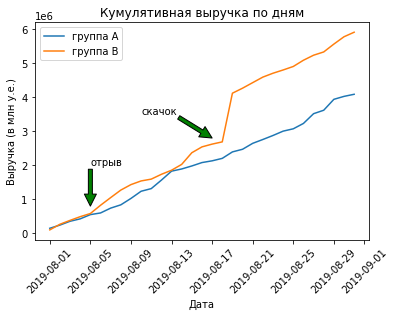

In [16]:
# Строю график выручки группы А
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='группа A')

# Строю график выручки группы B
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='группа B')

plt.xticks(rotation = 45) # поворот меток оси Х на 45
plt.title('Кумулятивная выручка по дням', fontsize=12) # вывод названия
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Выручка (в млн у.е.)")
plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g')); # вывод легенды

Выручка почти равномерно увеличивается в течение всего теста. Это хороший знак. Однако график выручки в группе В в моменте резко вырос. Это может сигнализировать о всплеске числа заказов, либо о появлении очень дорогих заказов в выборке. Такие выбросы необходимо проанализировать.

### Графики среднего чека 

Построю графики среднего чека по группам — разделю кумулятивную выручку на кумулятивное число заказов:

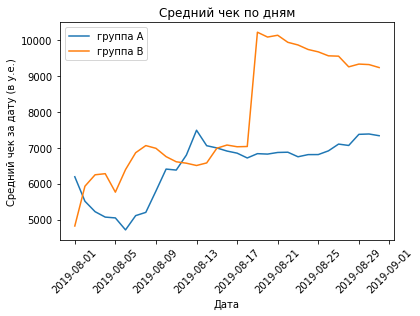

In [17]:
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'] / cumulative_revenue_A['orders'], label='группа A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'] / cumulative_revenue_B['orders'], label='группа B')
plt.xticks(rotation = 45)
plt.title('Средний чек по дням', fontsize=12)
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Средний чек за дату (в у.е.)");

Кумулятивное значение среднего чека сильно колеблется. Скорее всего принимать решение по этой метрике рано. Требуется дополнительный анализ выбросов, которые искажают рзультаты. Средний чек пока для обеих групп становится равномерным ближе к концу теста: установился для группы A и падает для группы B. Возможно, в группу B в первой половине теста попали крупные заказы (резкий всплеск на графике). Нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

### График относительного различия для среднего чека 

Построю график относительного различия для среднего чека. Для этого объединю таблицы cumulative_revenue_A и cumulative_revenue_B методом merge() так, чтобы она содержала столбцы: `date`, `revenue_A`, `revenue_B`, `orders_A`, `orders_B`]. Сохраню в переменной `merged_сumulative_revenue`. Добавлю горизонтальную ось методом `axhline()`:

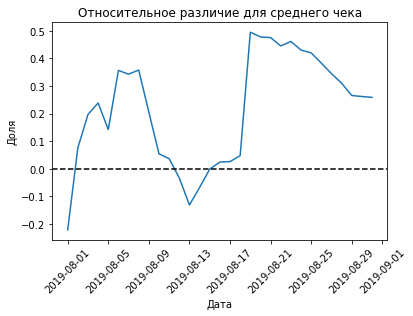

In [18]:
# собираю данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B, left_on='date', right_on='date', how='left', suffixes=['_A', '_B'])

# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenue_B'] / merged_cumulative_revenue['orders_B']) / (merged_cumulative_revenue['revenue_A'] / merged_cumulative_revenue['orders_A']) -1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation = 45)
plt.title('Относительное различие для среднего чека', fontsize=12)
plt.xlabel("Дата")
plt.ylabel("Доля");

Из построенного графика относительного изменения кумулятивного среднего чека группы B к группе A видно, что результаты теста значительно и резко менялись в несколько дат. Видимо, именно тогда были совершены аномальные заказы, которые искажают реузльтаты тестов.

### График кумулятивной конверсии

Аналогично проанализирую график кумулятивной конверсии.

In [19]:
print('Минимальное значение даты -', orders['date'].min())
print('Максимальное значение даты -',orders['date'].max())

Минимальное значение даты - 2019-08-01 00:00:00
Максимальное значение даты - 2019-08-31 00:00:00


Задам масштаб осей методом plt.axis(). Передам ему минимальное и максимальное значения оси x; минимальное и максимальное значения оси y — ["2019-08-01", '2019-08-31', 0, 0.07]:

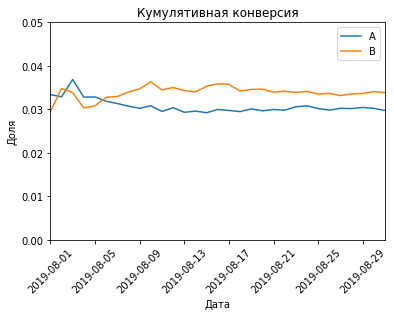

In [20]:
# считаю кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяю данные по группе A
cumulative_data_A = cumulative_data[cumulative_data['group'] == 'A']

# отделяю данные по группе B
cumulative_data_B = cumulative_data[cumulative_data['group'] == 'B']

# строю графики
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B')
plt.xticks(rotation = 45)
plt.legend()

# задаю масштаб осей
plt.axis(["2019-08-01", '2019-08-31', 0, 0.05])
plt.title('Кумулятивная конверсия', fontsize=12)
plt.xlabel("Дата")
plt.ylabel("Доля");

Практически в самом начале исследования конверсия сегментов А и В выровнялись и зафиксировались примерно около одного значения. Конверсия сегмента В выше сегмента А.

### График относительного изменения кумулятивной конверсии

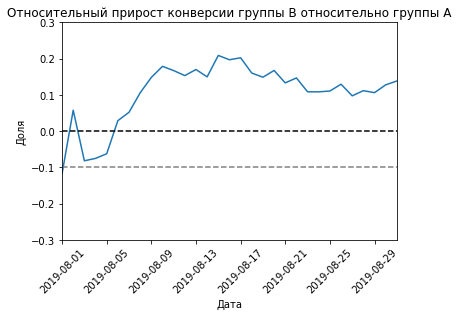

In [21]:
merged_cumulative_conversions = cumulative_data_A[['date','conversion']].merge(cumulative_data_B[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['_A', '_B'])

plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversion_B']/merged_cumulative_conversions['conversion_A'] -1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.3, 0.3])
plt.xticks(rotation = 45)
plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.xlabel("Дата")
plt.ylabel("Доля");

Практически с самого начала теста группа В начала лидировать по конверсии, становилась все лучше и лучше, возможно, даже зафиксировалась около прироста примерно в 10% относительно группы А. В целом отношение конверсии точно ещё не установилось и сейчас делать какие-либо выводы по тесту нельзя. Впрочем, сперва стоит проанализировать аномалии, возможно, они изменят картину.

### График количества заказов по пользователям

      visitor_id  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5


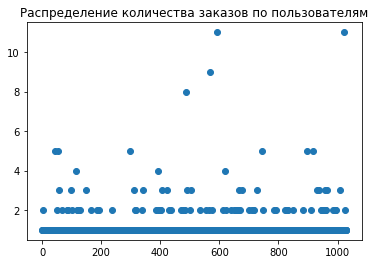

In [22]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users.columns = ['visitor_id', 'orders']

print(orders_by_users.sort_values(by='orders', ascending=False).head())

x_values = pd.Series(range(0, len(orders_by_users)))
plt.scatter(x_values, orders_by_users['orders'])
plt.title('Распределение количества заказов по пользователям');

Пользователей, заказавших более двух раз - совсем немного. Их вполне можно считать аномальными. Необходимо выяснить, в данной выборке 2 - это нормально или много. 

Посчитаю 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [23]:
print(np.percentile(orders_by_users['orders'], [95, 99])) 

[2. 4.]


Не более 5% пользователей сделали больше 2 заказов и не более 1% из всей выборки - больше 4 заказов.  Обычно принято отсеивать от 1% до 5% наблюдений с крайними значениями, поэтому будет разумным выбрать 2 заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней, т.е. исключить пользователей, совершивших 3 и более заказов.

### График стоимостей заказов

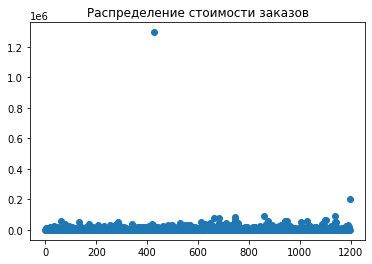

In [24]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x=x_values, y=orders['revenue'])
plt.title('Распределение стоимости заказов');

Присутствует немного дорогих заказов. По графику невозможно выбрать границу аномальных заказов. Выбросы слишком значительны, необходимо ограничить ось Y и посмотреть, как распределены значения:

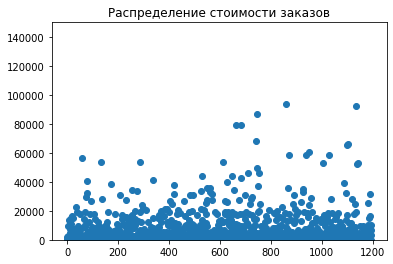

In [25]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x=x_values, y=orders['revenue'])
plt.ylim(0, 150000)
plt.title('Распределение стоимости заказов');

Теперь по графику можно выбрать примерную границу аномальных заказов - это около 50000 рублей. Проверю это значение, рассчитав 95-й и 99-й перцентили стоимости заказов. На основании полученных результатов выберу границу для определения аномальных заказов.

In [26]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Не более 5% заказов произведено на сумму от 28000 рублей и не более 1% - от 58000 рублей. Разумнее всего выбрать границу аномальных заказов в 30000 рублей.

### Расчет статистической значимости различий по «сырым» данным

На предыдущем шаге оценены результаты A/B-теста визуально и выявлено, что в данных, скорее всего, есть выбросы. Для выбросов найдены границы для их определения. Необходимо теперь посчитать статистическую значимость различий между группами по «сырым» данным (до удаления аномальных значений).

Для дальнейших исследований мне понадобится свобная таблица со следующими столбцами:

- date — дата;
- orders_per_date_A — количество заказов в выбранную дату в группе A;
- revenue_per_date_A — суммарная выручка в выбранную дату в группе A;
- orders_per_date_B — количество заказов в выбранную дату в группе B;
- revenue_per_date_B — суммарная выручка в выбранную дату в группе B;
- orders_cummulative_A — суммарное число заказов до выбранной даты включительно в группе A;
- revenue_cummulative_A — суммарная выручка до выбранной даты включительно в группе A;
- orders_cummulative_B — суммарное количество заказов до выбранной даты включительно в группе B;
- revenue_cummulative_B — суммарная выручка до выбранной даты включительно в группе B;
- visitors_per_date_A — количество пользователей в выбранную дату в группе A;
- visitors_per_date_B — количество пользователей в выбранную дату в группе B;
- visitors_cummulative_A — количество пользователей до выбранной даты включительно в группе A;
- visitors_cummulative_B — количество пользователей до выбранной даты включительно в группе B.

In [27]:
visitors_A_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_date_A']

visitors_A_cummulative = visitors_A_daily.apply(
    lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_A': 'sum'}
    ),
    axis=1,
)
visitors_A_cummulative.columns = ['date', 'visitors_cummulative_A']

visitors_B_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_date_B']

visitors_B_cummulative = visitors_B_daily.apply(
    lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_B': 'sum'}
    ),
    axis=1,
)
visitors_B_cummulative.columns = ['date', 'visitors_cummulative_B']

orders_A_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_A_daily.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

orders_A_cummulative = orders_A_daily.apply(
    lambda x: orders_A_daily[orders_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_A': 'sum', 'revenue_per_date_A': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_A_cummulative.columns = [
    'date',
    'orders_cummulative_A',
    'revenue_cummulative_A',
]

orders_B_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_B_daily.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

orders_B_cummulative = orders_B_daily.apply(
    lambda x: orders_B_daily[orders_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_B': 'sum', 'revenue_per_date_B': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_B_cummulative.columns = [
    'date',
    'orders_cummulative_B',
    'revenue_cummulative_B',
]

data = (
    orders_A_daily.merge(
        orders_B_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_B_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_A_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_B_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_B_cummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,orders_per_date_A,revenue_per_date_A,orders_per_date_B,revenue_per_date_B,orders_cummulative_A,revenue_cummulative_A,orders_cummulative_B,revenue_cummulative_B,visitors_per_date_A,visitors_per_date_B,visitors_cummulative_A,visitors_cummulative_B
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


#### Конверсия

Сформулирую гипотезы:

- **Нулевая**: различий в конверсии между группами нет.
- **Альтернативная**: различия в конверсии между группами есть.

Посчитаю статистическую значимость различия в конверсии между группами. Создам переменные `orders_by_users_A` и `orders_by_users_B` со столбцами [`visitor_id`, `orders`]. В них для пользователей, которые заказывали хотя бы 1 раз, укажу число совершённых заказов.

In [28]:
orders_by_users_A = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_A.columns = ['visitor_id', 'orders']

orders_by_users_B = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_B.columns = ['visitor_id', 'orders']

Объявлю переменные `sample_A` и `sample_B`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

Переменная `sample_A` должна состоять из двух частей:
- Список с количеством заказов для каждого из пользователей: `orders_by_users_A['orders']`.
- Нули для пользователей, которые ничего не заказывали. Их количество равно разнице между суммой посетителей и количеством записей о заказах: `data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])`.

Создам объект `pd.Series` нужной длины:

In [29]:
pd.Series(0, index=np.arange(data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])), name='orders')
[orders_by_users_A['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])), name='orders')]

sample_A = pd.concat(
    [
        orders_by_users_A['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_B = pd.concat(
    [
        orders_by_users_B['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Чтобы получить конверсию в группе, поделю сумму заказов на число пользователей — найду среднее в выборке `sample_A` методом `mean()`. Аналогично найдём конверсию группы B: `Sample_B.mean()`.
Выведу относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1. Округлю до трёх знаков после запятой.

In [30]:
print("{0:.3f}".format(stats.mannwhitneyu(sample_A, sample_B)[1]))

print("{0:.3f}".format(sample_B.mean() / sample_A.mean() - 1))

0.017
0.138


Первое число — p-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, можно отвергнуть в пользу альтернативной, т.е. различия в конверсии между группами есть и относительный выигрыш группы B равен 13.8%. Существует статистическая значимость различия конверсий между группами.

#### Средний чек

Теперь проверю статистическую значимость различий в среднем чеке между сегментами.

Сформулирую гипотезы:

- **Нулевая гипотеза**: различий в среднем чеке между группами нет.
- **Альтернативная гипотеза**: различия в среднем чеке между группами есть.

Чтобы рассчитать статистическую значимость различий в среднем чеке, передам критерию mannwhitneyu() данные о выручке с заказов. А также найду относительные различия в среднем чеке между группами:

In [31]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.729
0.259


P-value значительно больше 0.05 (равен 0.729). Значит, причин отвергать нулевую гипотезу в пользу альтернативной и считать, что в среднем чеке есть различия, нет. Однако, это странно, т.к. средний чек группы B значительно выше среднего чека группы A (примерно на 26%).

### Очистка данных

Найденные на предыдущих шагах 95-й и 99-й перцентили средних чеков равны 28000 и 58233.2 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя.

Приму за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 30000 рублей. Так я уберу 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаю срезы пользователей с числом заказов больше 2 — `users_with_many_orders` и пользователей, совершивших заказы дороже 30000 — `users_with_expensive_orders`. Объединю их в таблице `abnormal_users`.
Узнаю, сколько всего аномальных пользователей методом `shape()`:

In [32]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_A[orders_by_users_A['orders'] > 2]['visitor_id'],
        orders_by_users_B[orders_by_users_B['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > 30000]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head(5))
print(abnormal_users.shape)

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitor_id, dtype: int64
(68,)


Всего выявлено 68 аномальных пользователей. Необходимо подготовить выборки количества заказов по пользователям по группам теста:

In [33]:
sample_A_filtered = pd.concat(
    [
        orders_by_users_A[
            np.logical_not(orders_by_users_A['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_B_filtered = pd.concat(
    [
        orders_by_users_B[
            np.logical_not(orders_by_users_B['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

### Расчет статистической значимости различий по очищенным данным

#### Конверсия

Узнаю, как действия аномальных пользователей повлияли на результаты теста. Посчитаю статистическую значимость различий в конверсии между группами теста по очищенным данным. Применю статистический критерий Манна-Уитни к полученным выборкам:

In [34]:
print('{0:.3f}'.format(stats.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1]))
print('{0:.3f}'.format(sample_B_filtered.mean()/sample_A_filtered.mean()-1))

0.013
0.172


Конверсия по очищенным данным - 0.013, по "сырым" данным составляла 0.017 - практически не изменилась. Это значит, что нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, однозначно можно отвергнуть в пользу альтернативной, т.е. различия в конверсии между группами есть и относительный выигрыш группы B еще более увеличился и равен 17.2%. 

#### Средний чек

In [35]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.720
-0.023


Теперь все встало на свои места! P-value не изменился (был 0.729, а с вычищенными данными составил 0.72), что означает, что причин отвергать нулевую гипотезу в пользу альтернативной и считать, что в среднем чеке есть различия, нет. "Сырые" данные показали, что средний чек группы B на 25.9% **выше** среднего чека группы A, однако после удаления аномальных пользователей оказалось, что наоборот, чек группы B **ниже** среднего чека группы А на 2.3%, что является незначительным различием в пределах погрешности.

### Выводы по тесту

- Существует статистически значимое различие по конверсии между группами как по «сырым», так и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A и существует тенденция к улучшению.
- Продолжать тест смысла нет: группа B статистически значимо лучше группы A, а график конверсии говорит о фиксации результата.
- Можно тест остановить, зафиксировать победу группы В с перевесом по конверсии в 17%.

## Заключение

Вместе с отделом маркетинга подготовлен список гипотез для увеличения выручки интернет-магазина.

Целью данного исследования является приоритизация сформулированных гипотез, запуск A/B-теста и анализ полученных результатов.

Мною получены файл гипотез, а также 2 файла с результатами проведенного А/В теста в формате `.csv`. Файлы загружены, отображены, предварительно проанализированы с использованием встроенных библиотек `pandas`.

В результате предварительного анализа выявлено:

- в таблицах присутствует нарушение стиля названий столбцов таблиц;
- некоторые типы данных не соответствуют логике;
- в таблицах отсутствуют дубликаты и пропущенные значения.

На этапе предобработки данных:

- исправлены нарушения стиля в названиях столбцов,
- приведены типы данных в столбцах дат.
- обнаружено, что количество пользователей в исследуемых группах различается, также найдено 58 пользователей, присутствующие в обеих группах. По-хорошему, результаты теста с таким пересечением могут быть некорректными, т.к. это довольно сильное пересечение (около 10%), однако исследование было проведено.

Осуществлена приоретизация гипотез, в результате которой обозначены 5 гипотез, которые следует проверять первыми (в порядке приоритета):
- №1 - Добавление формы подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- №2 - Добавление блоков рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- №3 - Добавление двух новых каналов привлечения трафика, что позволит привлекать на 30% больше пользователей;
- №4 - Показ на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;
- №5 - Запуск акции, дающую скидку на товар в день рождения.

Полученные данные А/В теста проанализированы, построены следющие графики:
- кумулятивной выручки по группам;
- кумулятивного среднего чека по группам;
- относительного изменения кумулятивного среднего чека группы B к группе A;
- кумулятивной конверсии по группам;
- относительного изменения кумулятивной конверсии группы B к группе A;
- количества заказов по пользователям. 

На основании построенных графиков сделаны следующие выводы:

- выручка почти равномерно увеличивается в течение всего теста
- выборка содержит выбросы (в группе В был резкий всплеск числа заказов или совершены аномально дорогостоящие заказы), искажающие результат;
- по предварительным данным конверсия в группе В выше, чем в группе А;

Рассчитаны и визуализированы на точечных графиках:
- 95-й и 99-й перцентили количества заказов на пользователя;
- 95-й и 99-й перцентили стоимости заказов;

На основании полученных данных за аномальных пользователей приняты те, кто совершил от 2 заказов или совершил заказ дороже 30000 рублей. Таким образом были исключены 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с очень дорогими заказами. 

Посчитана статистическую значимость различий между группами по «сырым» и очищенным от аномалий данным. Сделаны следующие выводы:
- результаты группы B лучше группы A и существует тенденция к улучшению;
- продолжать тест смысла нет: группа B статистически значимо лучше группы A;
- тест целесообразно остановить, зафиксировать победу группы В с перевесом по конверсии в 17%.